In [4]:
import sktime
import numpy as np 
import pandas as pd 
from pickle import dump, load
import matplotlib.pyplot as plt

data = pd.read_csv('data/hdd.csv', parse_dates=['date'], index_col='date')
yt = data['target']

yt.tail()

date
2024-10-28    495.399994
2024-10-29    500.160004
2024-10-30    496.380005
2024-10-31    483.850006
2024-11-01    487.429993
Name: target, dtype: float64

Let our $Y_t$ be the "Close" column in the dataset. We will give the model a non-stationary time series to test its capability to identify and correct the situation. 

Instantiate the Arima class. 

In [5]:
import sys 
sys.path.append('../src/dev')
from arima import arima_trend
ac = arima_trend()

Fit the model with a dictiionary containing the maximum values for each of the parameters in the ARIMA model.
1. $p$: Auto-regressive Order, determines the number of lag observations included in the model.
2. $d$: Differencing Order, determines the number of times that the raw observations are differenced.
3. $q$: Moving Average Order, determines the size of the moving average window.

The model will fit an ARIMA model to each of the different combinations. If the dataset is not stationary the model will take the difference of the dataset until it is stationary. 

In [6]:
model_fits = ac.arima_model(x= yt, maxord = dict(p=3,d=2,q=3))

Data is not stationary, Assessing max_d = 2
Fitting: 27 models


Fitting ARIMA models: 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


See the summary of the models fit by accsessing the `summary` key of the returned dictionary. 

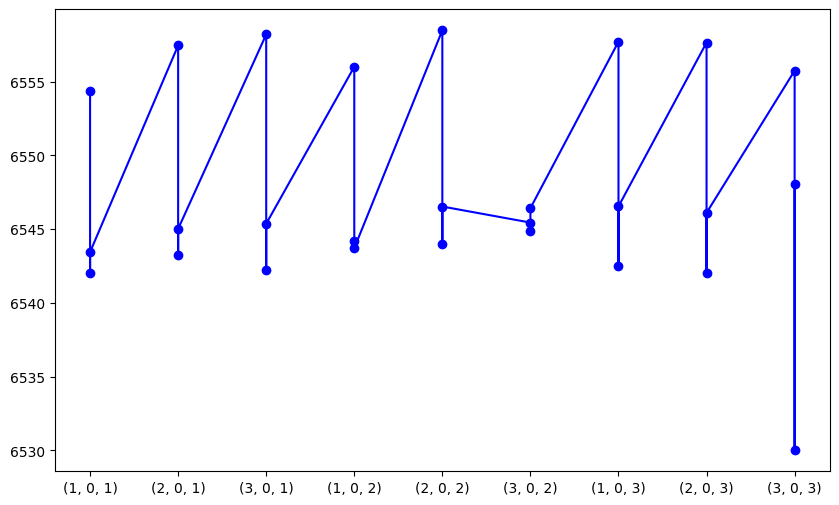

In [8]:
# Plotting shows the x-axis as the order of the model, and y-axis as the AIC value
mdf_summary = model_fits['summary']


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mdf_summary.index,mdf_summary['aic'], marker='o', linestyle='-', color='b')

In [9]:
# Checking if the model fit for the d parameters. 
model_fits.keys()

dict_keys(['best', (1, 0, 1), (1, 1, 1), (1, 2, 1), (2, 0, 1), (2, 1, 1), (2, 2, 1), (3, 0, 1), (3, 1, 1), (3, 2, 1), (1, 0, 2), (1, 1, 2), (1, 2, 2), (2, 0, 2), (2, 1, 2), (2, 2, 2), (3, 0, 2), (3, 1, 2), (3, 2, 2), (1, 0, 3), (1, 1, 3), (1, 2, 3), (2, 0, 3), (2, 1, 3), (2, 2, 3), (3, 0, 3), (3, 1, 3), (3, 2, 3), 'summary', 'models_fit'])

The best model is the one with the lowest AIC Value, which is the Akaike Information Criterion. We can also accsess the best model via the `best` key of the returned dictionary. 

Lets take a look at the residuals of the best model. The residuals tell us about the error of the model. The goal of the ARIMA model is to capture and explain predictable patterns in the data. If the model is correcly specified, the residuals should resemble a white noise process. This indicates that they are uncorrelated with each other and have a constant variance. 

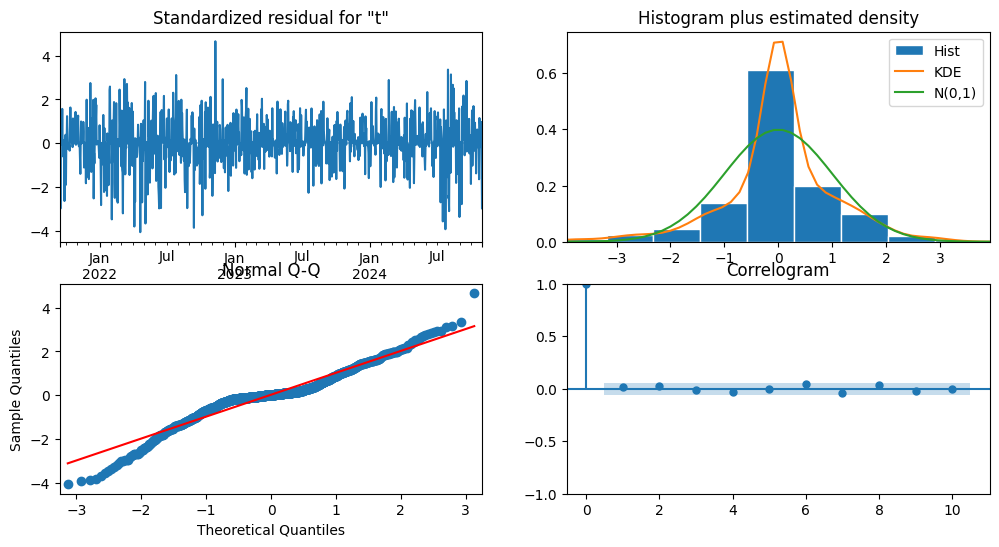

In [10]:
model =  model_fits['best']['model']
model.plot_diagnostics(figsize=(12, 6))
plt.show()

The above summary tells us that the model is able fit the data well, however taking a closer look at the Normal-QQ plot we can see that the the tails at the end of each suggest that their are some minor deviations at the both ends of the distribution. This is likely due to the outliers that can be seen in the residuals plot.

Next we obtain a forecast of the next 10 days. We can see that the model is able to capture the general trend of the data. 

In [11]:
ac.preds(mod = model, fh = 10, ci = .10)

,Mean Prediction,Lower,Upper
2024-11-02,486.784058,479.908265,493.659851
2024-11-03,486.217443,476.526420,495.908467
2024-11-04,485.977563,474.168258,497.786867
2024-11-05,486.167431,472.605056,499.729806
2024-11-06,486.700977,471.606588,501.795366
2024-11-07,487.341549,470.852248,503.830849
2024-11-08,487.806394,470.008389,505.604399
2024-11-09,487.890987,468.844520,506.937454
2024-11-10,487.558540,467.317239,507.799841
2024-11-11,486.955520,465.578252,508.332789


Finally we plot the residuals of the model. We can see that the residuals are uncorrelated with each other and have a constant variance. This is a good sign that the model is correctly specified.

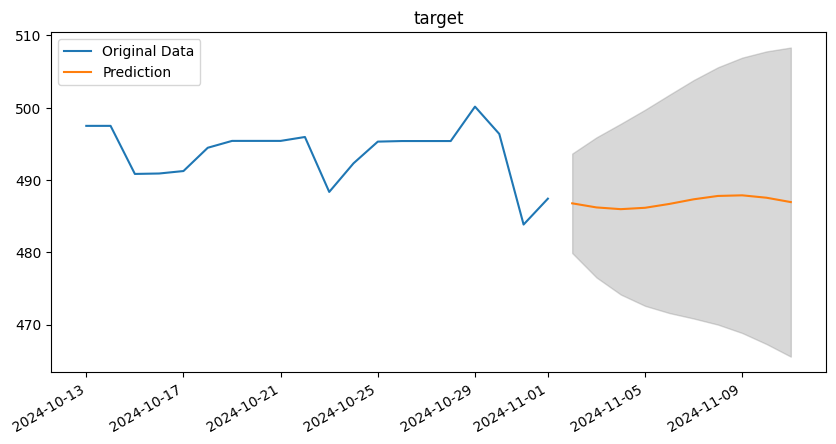

In [12]:

ac.plot_preds(mod = model, fh = 10, ci = .10)

In [14]:
# Evaluate by Auto Arima 

import pmdarima as pm 

best_model = pm.auto_arima(yt, 
        seasonal=False, stationary=False, 
        m=7, information_criterion='aic', 
        max_order=20,                                     
        max_p=10, max_d=2, max_q=10,                                     
        max_P=10, max_D=2, max_Q=10,                                   
        error_action='ignore',
        stepwise = True
)

print("best model --> (p, d, q):", best_model.order)
best_model.summary()

best model --> (p, d, q): (0, 1, 0)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  815
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2465.801
Date:                Mon, 27 Jan 2025   AIC                           4933.603
Time:                        13:54:04   BIC                           4938.305
Sample:                             0   HQIC                          4935.408
                                - 815                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        25.0432      1.028     24.355      0.000      23.028      27.059
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                45.89
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""